# Demo of the GTM Magic Analysis for Classification

In this demonstration we show how we chose the optimal GTM number of decorrelation layers for the hadron and gamma classes. Furthermore we use the models for both classes to bayes classify the test set and compare to the vine copula approach and kernel density estimator approach from this [non-parametric vines paper](https://www.sciencedirect.com/science/article/pii/S0047259X16300471).

In [1]:
from gtm import *

import os
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from demos.load_analyze_magic_data_helpers import *

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


got up one directory as new working directory so that loading data works. Should be in the package root.

In [2]:
# only run this once
os.chdir(os.path.dirname(os.getcwd()))
# print(os.getcwd())

### 1. Load Magic Data

We load the data for both groups as we did in the model training [script](demos/train_gtm_magic.py).

In [3]:
group = "h"

y_train_group_h, y_validate_group_h, y_test_group_h = load_magic_data(group=group,
                                                            train_portion=2/3,
                                                            data_dims=10,
                                                            poly_span_abs=12,
                                                            cross_validation_folds=5,
                                                            validation_fold_index=4,
                                                            split_random_state=25)
                

In [4]:
group = "g"

y_train_group_g, y_validate_group_g, y_test_group_g = load_magic_data(group=group,
                                                            train_portion=2/3,
                                                            data_dims=10,
                                                            poly_span_abs=12,
                                                            cross_validation_folds=5,
                                                            validation_fold_index=4,
                                                            split_random_state=25)
                

### 2. Classification of Test Set

We iteratively load the models for every number of decorrelation layer for both classes and classify with them to see how much the number of decorrelation layers affects the test set classficiation.
We see that even a 3 layer models classifies qite well. 

In [5]:
res_table = pd.DataFrame()
fpr_list = [0.01,0.02,0.05,0.1,0.2]
res_table["FPR"] = fpr_list

for num_decorr_layers in [3,4,5,6,7,8,9]:

    group = "h"
    loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'), weights_only=False)
    loaded_model_h = loaded_model_h.to('cpu')

    group = "g"
    loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'), weights_only=False)
    loaded_model_g = loaded_model_g.to('cpu')

    
    
    table_roc_curve = magic_classification_report(loaded_model_g,
                                                  loaded_model_h,
                                                  y_test_group_g,
                                                  y_test_group_h,
                                                  y_train_group_h,
                                                  y_train_group_g,
                                                  phi_g=0.5,
                                                  phi_h=0.5)
    model_tpr = []
    for fpr_quantile in [0.01,0.02,0.05,0.1,0.2]:
        model_tpr.append([
            np.round(table_roc_curve.loc[table_roc_curve.fpr <= fpr_quantile].tail(1)["tpr"].item(),3)
        ])
    res_table["GCTM_"+str(num_decorr_layers)] = np.stack(model_tpr)
    
res_table["Vine-Copula"] = [0.335,0.428,0.652,0.780,0.918]
res_table["MV-Kernel-DE"] = [0.335,0.408,0.567,0.730,0.868]

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,


In [6]:
res_table

,FPR,GCTM_3,GCTM_4,GCTM_5,GCTM_6,GCTM_7,GCTM_8,GCTM_9,Vine-Copula,MV-Kernel-DE
0,0.01,0.342,0.319,0.312,0.317,0.310,0.309,0.292,0.335,0.335
1,0.02,0.453,0.397,0.455,0.412,0.414,0.442,0.448,0.428,0.408
2,0.05,0.639,0.637,0.634,0.645,0.650,0.655,0.650,0.652,0.567
3,0.10,0.796,0.812,0.818,0.816,0.816,0.805,0.810,0.780,0.730
4,0.20,0.916,0.920,0.923,0.924,0.922,0.926,0.922,0.918,0.868


Since we need to chose a model per class we decide to choose the model based on the validation set likelihood as the number of decorrelation layers is just another hyperparameter like the penalities.

In [7]:
val_ll_h = []
val_ll_g = []

for num_decorr_layers in [3,4,5,6,7,8,9]:

    group = "h"
    loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
    loaded_model_h = loaded_model_h.to('cpu')

    group = "g"
    loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
    loaded_model_g = loaded_model_g.to('cpu')
    
    val_ll_h.append(loaded_model_h.log_likelihood(torch.FloatTensor(y_validate_group_h)).mean().detach().item())
    val_ll_g.append(loaded_model_g.log_likelihood(torch.FloatTensor(y_validate_group_g)).mean().detach().item())

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53916/921995457.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("demo

In [8]:
num_decorr_layers_val_ll_table = pd.DataFrame()
num_decorr_layers = [3,4,5,6,7,8,9]
num_decorr_layers_val_ll_table["num_decorr_layers"] = num_decorr_layers
num_decorr_layers_val_ll_table["val_ll_h"] = val_ll_h
num_decorr_layers_val_ll_table["val_ll_g"] = val_ll_g
#num_decorr_layers_val_ll_table.T

Below we see the optimal number of decorrelation layers is 6 for the gamma class and 8 for the hadron class.

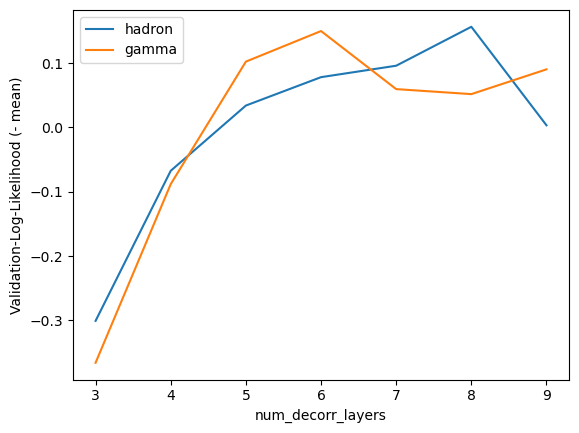

In [9]:
plt.plot(num_decorr_layers_val_ll_table["num_decorr_layers"],num_decorr_layers_val_ll_table["val_ll_h"]-num_decorr_layers_val_ll_table["val_ll_h"].mean(),label="hadron")
plt.plot(num_decorr_layers_val_ll_table["num_decorr_layers"],num_decorr_layers_val_ll_table["val_ll_g"]-num_decorr_layers_val_ll_table["val_ll_g"].mean(),label="gamma")
plt.xlabel('num_decorr_layers')
plt.ylabel('Validation-Log-Likelihood (- mean)')
plt.legend()
plt.show()

We finally compute the classification for the optial hyperparameter choice and plot the corresponding ROC Curve as well as add it to the table.

In [10]:
num_decorr_layers = num_decorr_layers_val_ll_table["num_decorr_layers"][num_decorr_layers_val_ll_table["val_ll_h"] == num_decorr_layers_val_ll_table["val_ll_h"].max()].item()
print("num_decorr_layers for h:",num_decorr_layers)
group = "h"
loaded_model_h = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
loaded_model_h = loaded_model_h.to('cpu')

num_decorr_layers = num_decorr_layers_val_ll_table["num_decorr_layers"][num_decorr_layers_val_ll_table["val_ll_g"] == num_decorr_layers_val_ll_table["val_ll_g"].max()].item()
print("num_decorr_layers for g:",num_decorr_layers)
group = "g"
loaded_model_g = torch.load(os.path.join("demos", "models", f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth"), map_location=torch.device('cpu'))
loaded_model_g = loaded_model_g.to('cpu')

table_roc_curve = magic_classification_report(loaded_model_g,
                                              loaded_model_h,
                                              y_test_group_g,
                                              y_test_group_h,
                                              y_train_group_h,
                                              y_train_group_g,
                                              phi_g=0.5,
                                              phi_h=0.5)


model_tpr = []
for fpr_quantile in [0.01,0.02,0.05,0.1,0.2]:
    model_tpr.append([
        np.round(table_roc_curve.loc[table_roc_curve.fpr <= fpr_quantile].tail(1)["tpr"].item(),3)
    ])
res_table["GCTM_"+"opt"] = np.stack(model_tpr)

num_decorr_layers for h: 8
num_decorr_layers for g: 6


/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53916/748904739.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("demo

(-0.05, 1.0)

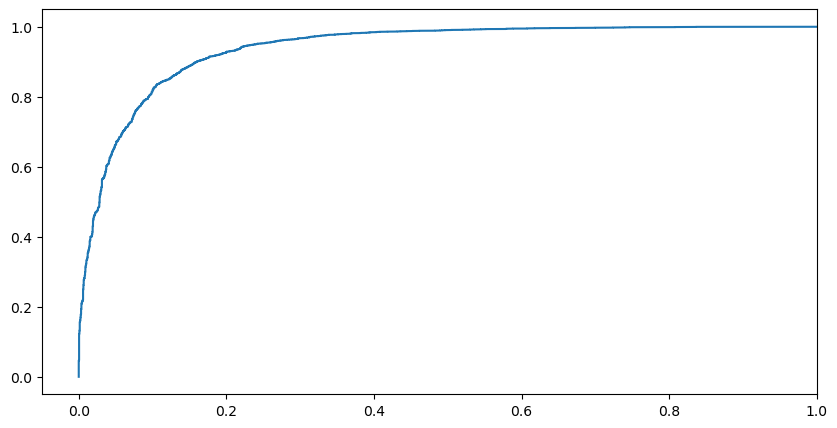

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(table_roc_curve["fpr"],table_roc_curve["tpr"])
plt.xlim(-0.05,1)

The GTM outperforms the Vine-Copula nad MV-Kernel-DE at every FPR except 0.010.

In [12]:
res_table.T

,0,1,2,3,4
FPR,0.010,0.020,0.050,0.100,0.200
GCTM_3,0.342,0.453,0.639,0.796,0.916
GCTM_4,0.319,0.397,0.637,0.812,0.920
GCTM_5,0.312,0.455,0.634,0.818,0.923
GCTM_6,0.317,0.412,0.645,0.816,0.924
GCTM_7,0.310,0.414,0.650,0.816,0.922
GCTM_8,0.309,0.442,0.655,0.805,0.926
GCTM_9,0.292,0.448,0.650,0.810,0.922
Vine-Copula,0.335,0.428,0.652,0.780,0.918
MV-Kernel-DE,0.335,0.408,0.567,0.730,0.868
